In [83]:
import pandas as pd
import numpy as np
import seaborn as sb
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

CREATING THE DATAFRAME OF PAIRS OF DIRECTORS AND ACTORS

In [11]:
movie_industry = pd.read_csv("../data/movie_industry.csv", encoding = "ISO-8859-1" )
movie_industry.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986


In [13]:
class Graph:
    """ Wrapper class Graph to create a bipartite graph
    Takes in the following paramaters
    directors_to_actors_relation : Dataframe with the data for directors and actors
    weight func : function which defined the weight of an edge. Takes the dateframe to calcuate weights from and
    the nodes values to calculate for
    weight_func_args : column names used to calculate the weights
    director_column : Column name for director
    actor_column : Column name for actor, 
    bipartite : default true
    """
    def __init__(self, 
                 directors_to_actors_relation, 
                 weight_func, 
                 weight_func_args, 
                 director_column="director", 
                 actor_column="star", 
                 bipartite=True):
        self.G = nx.Graph()
        
        directors = set(directors_to_actors_relation[director_column].values)
        actors = set(directors_to_actors_relation[actor_column].values)
    
        #store the director node as a tuple with director name and boolean True to indicate director
        for director in directors:
            self.G.add_node((director, True))
            
        #store the actor node as a tuple with actor name and boolean False to indicate actor
        for actor in actors:
            self.G.add_node((actor, False))

        #add weights to all edges
        for director in directors:
            rows = directors_to_actors_relation[directors_to_actors_relation[director_column] == director]
            for index in rows.index.values:
                self.G.add_edge((director, True), 
                                (rows.loc[index, actor_column], False), 
                                weight=weight_func(*[rows.loc[index, i] for i in weight_func_args], directors_to_actors_relation))             

In [14]:
#calcualtes edge weight as the number of collaborations
#takes in director name, star name and data to calculate weight from
def example_weight_func(director, star, df):
    return len(df.loc[((df["director"] == director) & (df["star"] == star))])

In [15]:
storage = Graph(movie_industry, example_weight_func, ["director", "star"])

In [45]:
directors = list(set(movie_industry["director"].values))
actors = list(set(movie_industry["star"].values))

In [56]:
collabs = []
for director in directors:
    for actor in actors:
        if storage.G.get_edge_data((director, True), (actor, False)):
            collabs.append(storage.G.get_edge_data((director, True), (actor, False))["weight"])
        else:
            collabs.append(0)

In [86]:
res =  [director for director in directors for i in range(len(actors))] 
df = pd.DataFrame({"director": res, 
                   "actor": actors*len(directors),
                  "collabs": collabs})
df

,director,actor,collabs
0,Mark Palansky,Joan Allen,0
1,Mark Palansky,Natasha Calis,0
2,Mark Palansky,Judith Hoag,0
3,Mark Palansky,Takaaki Enoki,0
4,Mark Palansky,Douglas Barr,0
...,...,...,...
6908531,Kathryn Bigelow,Aimee Teegarden,0
6908532,Kathryn Bigelow,JoBeth Williams,0
6908533,Kathryn Bigelow,Taylor Schilling,0
6908534,Kathryn Bigelow,Skyler Shaye,0


ADDING AND TESTING COVARIATES

In [66]:
actor_total_gross = {}
actor_mean_gross = {}
for actor in actors:
    temp = movie_industry[movie_industry.star ==  actor]
    sum_gross = sum(temp.gross.values)
    mean_gross = np.mean(temp.gross.values)
    actor_total_gross[actor] = sum_gross
    actor_mean_gross[actor] = mean_gross

In [67]:
director_total_gross = {}
director_mean_gross = {}
for director in directors:
    temp = movie_industry[movie_industry.director ==  director]
    sum_gross = sum(temp.gross.values)
    mean_gross = np.mean(temp.gross.values)
    director_total_gross[director] = sum_gross
    director_mean_gross[director] = mean_gross

In [87]:
df["director_total_gross"] = df.director.map(director_total_gross)
df["director_mean_gross"] = df.director.map(director_mean_gross)
df["actor_total_gross"] = df.actor.map(actor_total_gross)
df["actor_mean_gross"] = df.actor.map(actor_mean_gross)

In [88]:
df["collab indicator"] = (df.collabs > 0)*1

In [89]:
df["total_gross_diff"] = abs(df.director_total_gross - df.actor_total_gross)
df["mean_gross_diff"] = abs(df.director_mean_gross - df.actor_mean_gross)

In [90]:
df

,director,actor,collabs,director_total_gross,director_mean_gross,actor_total_gross,actor_mean_gross,collab indicator,total_gross_diff,mean_gross_diff
0,Mark Palansky,Joan Allen,0,10011274.0,1.001127e+07,36634716.0,18317358.0,0,26623442.0,8.306084e+06
1,Mark Palansky,Natasha Calis,0,10011274.0,1.001127e+07,49130154.0,49130154.0,0,39118880.0,3.911888e+07
2,Mark Palansky,Judith Hoag,0,10011274.0,1.001127e+07,135265915.0,135265915.0,0,125254641.0,1.252546e+08
3,Mark Palansky,Takaaki Enoki,0,10011274.0,1.001127e+07,307775.0,307775.0,0,9703499.0,9.703499e+06
4,Mark Palansky,Douglas Barr,0,10011274.0,1.001127e+07,15369573.0,15369573.0,0,5358299.0,5.358299e+06
...,...,...,...,...,...,...,...,...,...,...
6908531,Kathryn Bigelow,Aimee Teegarden,0,210736809.0,2.634210e+07,10130219.0,10130219.0,0,200606590.0,1.621188e+07
6908532,Kathryn Bigelow,JoBeth Williams,0,210736809.0,2.634210e+07,40996665.0,40996665.0,0,169740144.0,1.465456e+07
6908533,Kathryn Bigelow,Taylor Schilling,0,210736809.0,2.634210e+07,4752353.0,4752353.0,0,205984456.0,2.158975e+07
6908534,Kathryn Bigelow,Skyler Shaye,0,210736809.0,2.634210e+07,10005534.0,10005534.0,0,200731275.0,1.633657e+07


In [97]:
bins = np.linspace(min(df.mean_gross_diff.values), max(df.mean_gross_diff.values), 50)

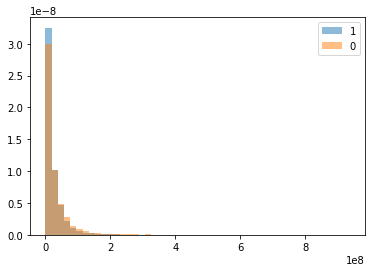

In [103]:
plt.hist(df[df["collab indicator"] == 1].mean_gross_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df[df["collab indicator"] == 0].mean_gross_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [114]:
np.var(df[df["collab indicator"] == 1].mean_gross_diff.values)

1050745802394769.9

In [111]:
np.var(df[df["collab indicator"] == 0].mean_gross_diff.values)

2096009318756957.0

In [118]:
from scipy.stats import ttest_ind

ttest_ind(df[df["collab indicator"] == 1].mean_gross_diff.values, 
                      df[df["collab indicator"] == 1].mean_gross_diff.values, 
                      equal_var=False)

Ttest_indResult(statistic=0.0, pvalue=1.0)